<a href="https://colab.research.google.com/github/ppujari/cvpr2020/blob/master/search_queries_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Query Categorization - Colab 0**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ppujari/cvpr2020/blob/master/search_queries_classification.ipynb)

Before opening the colab with the badge, you would need to allow Google Colab to access the GitHub private repositories. Please check therefore [this tutorial](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#:~:text=Navigate%20to%20http%3A%2F%2Fcolab,to%20read%20the%20private%20files.).

If colab is opened with this badge, make sure please **save copy to drive** in 'File' menu before running the notebook.

__author__ = "Pradeep Pujari"  
__version__ = "Version 0"  
  
## Contents

1. [Overview](#Overview)
2. [Set-up](#Set-up)
3. [Data Exploration](#Data-Exploration)
  1. [Visualization](#Visualization)
4. [Common Approaches for Categorization](#Common-Approaches-for-Categorization)
  1. [Preprocessing](#Preprocessing)
5. [Base Model](#Base-Model)
  1. [BERT](#BERT)
  1. [BERT sentence-level classifier](#BERT-sentence-level-classifier)
6. [Further Research](#Further-Research)


## Overview  
Grainger is North America's leading broad line supplier of maintenance, repair and operating (MRO) products. For nearly 100 years, we have helped customers access useful information to find the products they need to get their jobs done.

Internet search has become a part of many people’s daily life and work. Given the exponential growth of information’s availability in electronic form, search becomes one of the most important and effective approaches to finding correct/relevant information to serve our needs. A user can type in key words in a search engine to find out where to buy a product and whether a certain price is a good price.  

It is not uncommon that a search engine returns irrelevant, misleading or incorrect results after you type in a query. In another time, the  relevance results are returned but down to the bottom of a long result list.  

Text classification and categorization is a well-known topic in Information Retrieval and Text Mining fields. Most work in this area has been focused on categorizing Web pages or longer text or corpus. However, search query classification is very different in the sense that queries are usually very short on the one hand, and with implicit and subjective user intents on the other hand. Therefore, how to automatically understand user search intents given the search queries would be very interesting to me.


## Setup

In [1]:
!pip install transformers
!pip install xgboost
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=4bcf504da546f8cdbee4c964ab21945cb04462f698b9e81682649cb4701ef3d0
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier
import torch
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt

## Data Exploration ##

In [4]:
data_df = pd.read_csv('./data_train.tsv', sep='\t', names=('query','class_label'))

In [ ]:
data_df.head()

,query,class_label
0,mvbe,ID_681575024
1,sanax,ID_628496423
2,gas lighter,ID_765419922
3,stopper,ID_930030564
4,5 minute timer,ID_337225844


In [8]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
data_df = data_df.apply(lambda x: x.astype(str).str.lower())

In [ ]:
data_df.sample(10)

,query,class_label
1748191,834-6371 5m,id_332853642
793582,welding lens 2 x 4 in #9 auto-darkening,id_176957691
5457045,wire basket strainer,id_474618556
4536795,locking glass door cabinets,id_699945089
5180617,broan 600 cfm heat recovery ventilator,id_763998702
5060663,"drain cover 6-1/2""",id_474618556
3204018,3 way dimmers,id_660527849
4120303,glass door fire and smoke seal,id_494064904
414459,rae travel adaptor,id_209028105
1526373,platinum ultra-accurate stainless steel digita...,id_835404533


In [ ]:
data_df.shape

(6128532, 2)

In [ ]:
#How many unique categories?
print(len(data_df.class_label.unique().tolist()))

485


In [ ]:
#drop nan rows
data_df = data_df.dropna(axis=0)
data_df.shape

(6128532, 2)

## Visualization

<Axes: xlabel='class_label'>

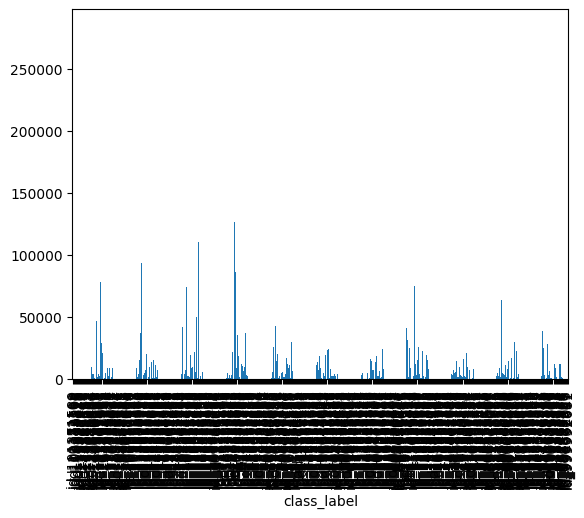

In [ ]:
data_df.groupby(['class_label']).size().plot.bar()

In [ ]:
# Function to count words in a sentence
def count_words(sentence):
    words = sentence.split()
    return len(words)

In [ ]:
# Apply the count_words function to the 'query' column and store the result in a new column 'word_count'
data_df['word_count'] =data_df['query'].apply(count_words)

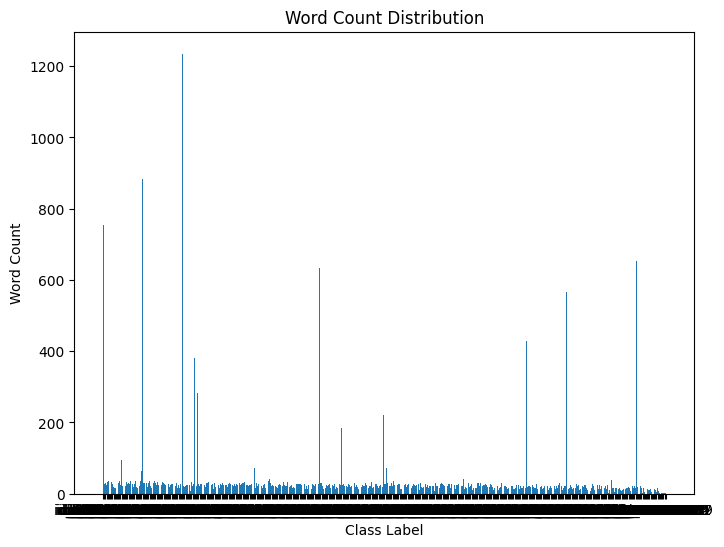

In [ ]:
# Plot a bar graph to show word count distribution
plt.figure(figsize=(8, 6))
plt.bar(data_df['class_label'], data_df['word_count'])
plt.xlabel('Class Label')
plt.ylabel('Word Count')
plt.title('Word Count Distribution')
plt.show()

Augmenting search **ONE WORD** queries, may augmented with more semantic meaning with Tools like WordNet and WikiPedia.

**One query does not belong to multiple categories. So, multi label scenerio not considered**

## Common Approaches for Categorization

1. **Preprocessing**  
    Reduce the impact of noise in queries
2. **Gathering extra information to augment the queries.**  
    WordNet to expand queries.  
    LLMs to word completion.  
3. **Modeling**  
    Query / term clustering.    
    Lexical relational structure in queries.  
    Creating phrase list.

## Base Model

-load the file contents and the categories  
-extract feature vectors suitable for machine learning  
-train a linear model to perform categorization  
-use a grid search strategy to find a good configuration of both the feature extraction components and the classifier  


In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.

Bags of words
The most intuitive way to do so is to use a bags of words representation:

Assign a fixed integer id to each word occurring in any document of the training set (for instance by building a dictionary from words to integer indices).

For each document #i, count the number of occurrences of each word w and store it in X[i,j] as the value of feature #j where j is the index of word w in the dictionary.

The bags of words representation implies that n_features is the number of distinct words in the corpus: this number is typically larger than 100,000.

If n_samples == 10000, storing X as a NumPy array of type float32 would require 10000 x 100000 x 4 bytes = 4GB in RAM which is barely manageable on today’s computers.

Fortunately, most values in X will be zeros since for a given document less than a few thousand distinct words will be used. For this reason we say that bags of words are typically high-dimensional sparse datasets. We can save a lot of memory by only storing the non-zero parts of the feature vectors in memory.

scipy.sparse matrices are data structures that do exactly this, and scikit-learn has built-in support for these structures.

**Tokenizing text with scikit-learn**   
Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer, which builds a dictionary of features and transforms documents to feature vectors:


In [7]:
le = preprocessing.LabelEncoder()
categories = le.fit_transform(data_df.class_label.values)

In [ ]:
print(categories[:10])

[310 277 360 445 123 158 367 121  94 189]


In [ ]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(data_df['query'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_counts,categories,test_size=0.20, shuffle=True,random_state=42)


In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.fit_transform(X_test)

**Naive Bayes**

In [ ]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)
predicted = clf.predict(X_test_tfidf)
np.mean(predicted == y_test)

0.5159715984325781

## Classification using embeddings

In [11]:
def get_embeddings(texts):
    #Sentences are encoded by calling model.encode()
    try:
      embeddings = model.encode(texts)
    except:
      return None
    return embeddings

In [ ]:
data_df["embedding"] = data_df['query'].apply(lambda x: get_embeddings(x))

In [ ]:
data_df.head()

In [ ]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    list(data_df.embedding.values), categories, test_size=0.2, random_state=42)

In [ ]:
# train random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
np.mean(predicted == y_test)

**SVM**

In [ ]:
clf = svm.SVC().fit(X_train, y_train)
predicted = clf.predict(X_test)
np.mean(predicted == y_test)

In [ ]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
predicted = clf.predict(X_test)
np.mean(predicted == y_test)

**stochastic gradient descent (SGD)**

In [ ]:
clf = SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None)
clf = clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
np.mean(predicted == y_test)

In [ ]:
#parameters = {
#     'vect__ngram_range': [(1, 1), (1, 2)],
#     'tfidf__use_idf': (True, False),
#     'clf__alpha': (1e-2, 1e-3),
# }

In [ ]:
#text_clf = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
#     ('clf', MultinomialNB()),])

In [ ]:
#text_clf.fit(X_train, y_train)

In [ ]:
#gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [ ]:
#predicted = gs_clf.predict(X_test)
#np.mean(predicted == y_test)

## BERT

### BERT sentence-level classifier

As next approach, we'll use BERT representations as the input to a classifier model. The first step is to combine the individual word representations into fixed dimensional vectors, so that we can use them as inputs to a classifier. For this, I'll just average the individual vectors:

In [ ]:
def bert_reduce_mean(X):
    return X.mean(axis=1)

In [ ]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
max_length = 32  # Specify your desired maximum sequence length

In [ ]:
# Define a custom PyTorch Dataset for text classification
class TextClassificationDataset(Dataset):
    def __init__(self, text, labels):
        self.texts = text
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
# Apply label encoding to class labels
label_encoder = LabelEncoder()
data_df['class_label'] = label_encoder.fit_transform(data_df['class_label'])
num_classes = len(label_encoder.classes_)

In [ ]:
data_df.head()

In [ ]:
def convert_to_bert_input(text):
  x = tokenizer(text, padding='max_length', truncation=True,max_length=max_length,return_tensors='pt')
  return x


In [ ]:
data_df['query_n'] = data_df['query'].apply(lambda x : convert_to_bert_input(x))

In [ ]:
# Split the data into train and test sets
train_data, test_data = train_test_split(data_df, test_size=0.1, random_state=42)


In [ ]:
# Convert text and labels into the custom Dataset
train_dataset = TextClassificationDataset(train_data['query_n'].values, train_data['class_label'].values)
test_dataset = TextClassificationDataset(test_data['query_n'].values, test_data['class_label'].values)

In [ ]:
# Function to get BERT embeddings for a single text
def get_bert_embeddings(text):
    inputs = tokenizer(text, padding=True, truncation=True,max_length=max_length,return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings


In [ ]:
# Define a BERT classifier model
class BERTClassifier(torch.nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = model
        self.dropout = torch.nn.Dropout(0.2)
        self.fc = torch.nn.Linear(hidden_size, num_classes)
        #self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_id, mask):
        #print(input_id)
        _,pooled_output = self.bert(input_id, mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        logits = self.fc(dropout_output)
        return logits

In [ ]:
# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Initialize the BERT classifier model
num_classes = data_df['class_label'].nunique()
classifier = BERTClassifier(model.config.hidden_size, num_classes).to(device)

In [ ]:
# Set training parameters
batch_size = 64
epochs = 1
lr = 2e-5

In [ ]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss().to(device)


In [ ]:
# Training loop
for epoch in range(epochs):
    classifier.train()
    total_loss = 0
    total_acc_train = 0
    progress_bar = tqdm(train_loader, desc='Epoch {:1d}'.format(epoch+1), leave=False)

    for texts,labels in progress_bar:
 #       print(texts)
        bert_text = texts['input_ids'].squeeze(1).to(device)
        mask = texts['attention_mask'].to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        #print(bert_text)
        outputs = classifier(bert_text,mask)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        acc = (outputs.argmax(dim=1) == labels).sum().item()
        total_acc_train += acc
    progress_bar.set_postfix({'Training loss': '{:.3f}'.format(total_loss / len(train_dataset)),\
        'Train Accuracy':'{:.3f}'.format(total_acc_train / len(progress_bar))})


In [ ]:
# Evaluation
classifier.eval()
predictions = []
true_labels = []
with torch.no_grad():
      for texts, labels in test_loader:
        token_ids = texts['input_ids'].squeeze(1).to(device)
        mask = texts['attention_mask'].to(device)
        labels = labels.to(device)

        outputs = classifier(token_ids,mask)
        _, preds = torch.max(outputs, 1)

        predictions.extend(preds.tolist())
        true_labels.extend(labels.tolist())


In [ ]:
accuracy = accuracy_score(true_labels, predictions)
print('Epoch {:1d} - Accuracy: {:.4f}'.format(epoch+1, accuracy))

## Further Research ##

**Query enrichment via click-through links**  
Automatically extract click-through links from the query log (which provides us with the title of
the image that the user clicks) to enrich the query. To further exploit the click-through link, we find
to extract its keywords also.
